In [1]:
import datetime as dt

import matplotlib.pyplot as plt

import pandas as pd

import pydotplus

from IPython.display import Image

from sklearn import metrics
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import export_graphviz
from sklearn.utils import resample

# Classification (with labels given by the clustering)

## Decision tree

In [2]:
customer_profile = pd.read_csv('datasets/customer_indicators.csv', index_col=0)
customer_clustering = pd.read_csv('datasets/clustering_labels.csv', index_col=0)
customer_clustering = customer_clustering.merge(customer_profile[['CustomerID', 'RFrequency']], on='CustomerID')
del customer_profile

In [3]:
df_majority = customer_clustering[customer_clustering.Label == 'Medium']
df_minority = customer_clustering[customer_clustering.Label == 'High']
df_middle   = customer_clustering[customer_clustering.Label == 'Low']

customer_clustering.Label.value_counts()

Medium    1698
Low       1250
High       912
Name: Label, dtype: int64

In [4]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority))

# Upsample minority class
df_middle_upsampled = resample(df_middle, 
                               replace=True,     # sample with replacement
                               n_samples=len(df_majority))

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled, df_middle_upsampled])
 
# Display new class counts
customer_clustering = df_upsampled
df_upsampled.Label.value_counts()

High      1698
Low       1698
Medium    1698
Name: Label, dtype: int64

In [5]:
# Function to discretize the variables
# Input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        mapping = {'High': 0, 'Medium': 1, 'Low': 2}

        # Add a new colum with the number representation of the variable
        dataset[variable + '_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [6]:
variables = ['Label']

# Discretize data, in this case only Label
customer_clustering = discretize_data(customer_clustering, variables)

# Drop the categorical variables since we don't need them anymore 
customer_clustering = customer_clustering[['Delta', 'Label_num', 'RFrequency']]

label = customer_clustering.pop('Label_num')

scaler = StandardScaler()
customer_clustering = scaler.fit_transform(customer_clustering.values)

train_set, test_set, train_label, test_label = train_test_split(
                                                 customer_clustering, label, stratify=label, test_size=0.3)

In [7]:
# Decision tree

dec_t = tree.DecisionTreeClassifier(criterion='gini', splitter='best',
                                  max_depth=4,
                                  min_samples_split=3, min_samples_leaf=10)

dec_t = dec_t.fit(train_set, train_label)

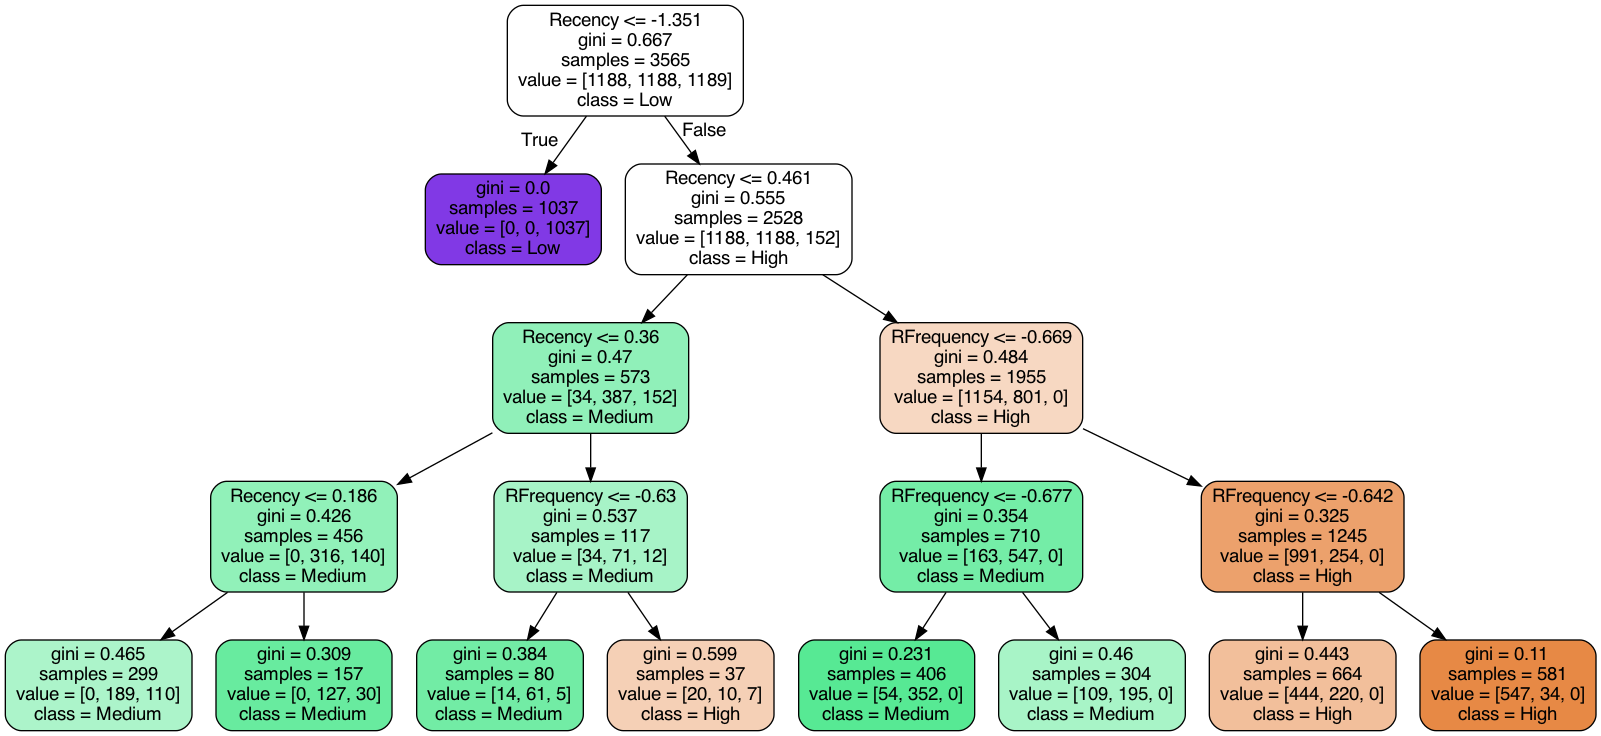

In [8]:
# Show decision tree

dot_data = tree.export_graphviz(dec_t, out_file=None,
                         feature_names=['Recency', 'RFrequency'],
                         class_names=['High', 'Medium', 'Low'],
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [9]:
# Predict phase

train_pred_dt = dec_t.predict(train_set)
test_pred_dt = dec_t.predict(test_set)

In [10]:
# Evaulate the accuracy on the train set and the test set

print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.8336605890603086
Accuracy test set  0.8371484630477436
Precision train set  0.8434387879005714
Recall train set  0.8336605890603086
F1 score train set  0.8365545698174708
Support train set  (array([0.78861154, 0.74157303, 1.        ]), array([0.8510101 , 0.77777778, 0.87216148]), array([0.81862348, 0.75924404, 0.93171608]), array([1188, 1188, 1189]))


## SVM

In [11]:
#linear,poly,rbf,sigmoid,precomputed
from sklearn.svm import SVC

svm = SVC(kernel='poly', C=0.5, gamma='scale')
svm.fit(train_set, train_label)

SVC(C=0.5, kernel='poly')

In [12]:
#prediction on the test test
test_pred_proba_svm = svm.predict(train_set)

In [13]:
test_pred_svm = svm.predict(test_set)

In [23]:
#compute the performance of the model
print(classification_report(train_label, 
                            test_pred_proba_svm, 
                            target_names=['High', 'Medium', 'Low']))

              precision    recall  f1-score   support

        High       0.65      0.69      0.67      1188
      Medium       0.59      0.62      0.60      1188
         Low       1.00      0.87      0.93      1189

    accuracy                           0.73      3565
   macro avg       0.74      0.73      0.73      3565
weighted avg       0.74      0.73      0.73      3565



In [15]:
#compute the performance of the model
print(classification_report(test_label, 
                            test_pred_svm, 
                            target_names=['High', 'Medium', 'Low']))

              precision    recall  f1-score   support

        High       0.66      0.68      0.67       510
      Medium       0.60      0.65      0.62       510
         Low       1.00      0.88      0.94       509

    accuracy                           0.74      1529
   macro avg       0.75      0.74      0.74      1529
weighted avg       0.75      0.74      0.74      1529



## KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=4, algorithm='ball_tree', metric='minkowski').fit(train_set, train_label)

In [17]:
#prediction on the test test
train_pred_knn = knn.predict(train_set)

#compute the performance of the model

print(classification_report(train_label, 
                            train_pred_knn, 
                            target_names=['High', 'Medium', 'Low']))

              precision    recall  f1-score   support

        High       0.81      0.97      0.88      1188
      Medium       0.88      0.75      0.81      1188
         Low       0.98      0.93      0.96      1189

    accuracy                           0.88      3565
   macro avg       0.89      0.88      0.88      3565
weighted avg       0.89      0.88      0.88      3565



## Classification with Random Forest

In [18]:
# define and fit a random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=2,
                             max_depth=4, 
                             min_samples_split=2,
                             min_samples_leaf=8,
                             bootstrap=True) 
rf = rf.fit(train_set, train_label)

In [19]:
#prediction on the test test
train_pred_rf = rf.predict(train_set)

In [20]:
#compute the performance of the model

print(classification_report(train_label, 
                            train_pred_rf, 
                            target_names=['High', 'Medium', 'Low']))

              precision    recall  f1-score   support

        High       0.79      0.84      0.82      1188
      Medium       0.73      0.78      0.76      1188
         Low       1.00      0.87      0.93      1189

    accuracy                           0.83      3565
   macro avg       0.84      0.83      0.84      3565
weighted avg       0.84      0.83      0.84      3565

